In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pyaccel import lattice as pyacc_lat
from pyaccel import optics as pyacc_opt
from pyaccel.optics import calc_touschek_energy_acceptance
from mathphys.functions import save_pickle, load_pickle
from apsuite.dynap import DynapXY, DynapEX, PhaseSpace
import pyaccel
import pymodels

from idanalysis import orbcorr as orbcorr

from idanalysis import optics as optics
import utils

In [4]:
def create_model_ids(width, rescale_kicks, shift_kicks):
    """."""
    print('--- model with kickmap ---')
    ids = utils.create_ids(width=width, rescale_kicks=rescale_kicks,        shift_kicks=shift_kicks)
    # ids = utils.create_ids(phase, gap, rescale_kicks=1)
    model = pymodels.si.create_accelerator(ids=ids)
    model.cavity_on = False
    model.radiation_on = 0
    twiss, *_ = pyaccel.optics.calc_twiss(model, indices='closed')
    print('length : {:.4f} m'.format(model.length))
    print('tunex  : {:.6f}'.format(twiss.mux[-1]/2/np.pi))
    print('tuney  : {:.6f}'.format(twiss.muy[-1]/2/np.pi))
    straight_nr = int(ids[0].subsec[2:4])
    # get knobs and beta locations
    if straight_nr is not None:
        _, knobs, _ = optics.symm_get_knobs(model, straight_nr)
        locs_beta = optics.symm_get_locs_beta(knobs)
    else:
        knobs, locs_beta = None, None

    return model, knobs, locs_beta

In [5]:
def create_models(width, rescale_kicks, shift_kicks):

    # create unperturbed model for reference
    model0 = pymodels.si.create_accelerator()
    model0.cavity_on = False
    model0.radiation_on = 0

    # print(model0.length)
    # print(twiss0.mux[-1]/2/np.pi)
    # print(twiss0.muy[-1]/2/np.pi)

    # create model with id
    model1, knobs, locs_beta = create_model_ids(width, rescale_kicks=rescale_kicks, shift_kicks=shift_kicks)


    twiss1, *_ = pyacc_opt.calc_twiss(model1, indices='closed')
    # print(model1.length)
    # print(twiss1.mux[-1]/2/np.pi)
    # print(twiss1.muy[-1]/2/np.pi)

    # return

    return model0, model1, knobs, locs_beta

In [6]:
def analysis_dynapt_mp(width, corr=None, i=0):

   
    model0 = pymodels.si.create_accelerator()
    model1 = pymodels.si.create_accelerator()
    model1[2267].pass_method = 'str_mpole_symplectic4_pass'
    model1[2269].pass_method = 'str_mpole_symplectic4_pass'
    pol_b_array = np.array([
        6.27715508e-09,  3.01548309e-06,  1.77022450e-02,  1.95178565e-02,
        6.42386448e+01, -3.10339225e+03])


    pol_b_array *=0.5
    pol_b = pol_b_array.tolist()
    model1[2267].polynom_b = pol_b
    model1[2269].polynom_b = pol_b

    model0.radiation_on = 0
    model0.cavity_on = False
    model0.vchamber_on = True

    model1.radiation_on = 0
    model1.cavity_on = False
    model1.vchamber_on = True
    if corr is not None:
        orbcorr.correct_orbit_fb(
                model0, model1, 'IVU18', corr_system='SOFB')
        model0.radiation_on = 0
        model0.cavity_on = False
        model0.vchamber_on = True

        model1.radiation_on = 0
        model1.cavity_on = False
        model1.vchamber_on = True

    # if i == 0:
    #     dynapxy = DynapXY(model0)
    #     dynapxy.params.x_nrpts = 40
    #     dynapxy.params.y_nrpts = 20
    #     dynapxy.params.nrturns = 1*1024
    #     print(dynapxy)
    #     dynapxy.do_tracking()
    #     dynapxy.process_data()
    #     fig1, *ax = dynapxy.make_figure_diffusion(orders=(1, 2, 3, 4))
    #     fig1.show()
    #     fig1.savefig('./results/width_43/dynapt-nominal.png', dpi=300, format='png')

    
    dynapxy = DynapXY(model1)
    dynapxy.params.x_nrpts = 40
    dynapxy.params.y_nrpts = 20
    dynapxy.params.nrturns = 1*1024
    print(dynapxy)
    dynapxy.do_tracking()
    dynapxy.process_data()
    fig2, *ax = dynapxy.make_figure_diffusion(orders=(1, 2, 3, 4))
    fig2.show()

    
    fig2.savefig('./results/width_63/dynapt-multipoles-gap200.png', dpi=300, format='png')
   

In [9]:
def analysis_dynapt_map(width, shift, corr=None):

    rescale_kicks = 15.3846
    shift_kicks = [1e-6*shift, 0]
    model0, model1, *_ = create_models(width, rescale_kicks, shift_kicks)


    model0.radiation_on = 0
    model0.cavity_on = False
    model0.vchamber_on = True

    model1.radiation_on = 0
    model1.cavity_on = False
    model1.vchamber_on = True
    if corr is not None:
        orbcorr.correct_orbit_fb(
                model0, model1, 'IVU18', corr_system='SOFB')
        model0.radiation_on = 0
        model0.cavity_on = False
        model0.vchamber_on = True

        model1.radiation_on = 0
        model1.cavity_on = False
        model1.vchamber_on = True

    # if i == 0:
    #     dynapxy = DynapXY(model0)
    #     dynapxy.params.x_nrpts = 40
    #     dynapxy.params.y_nrpts = 20
    #     dynapxy.params.nrturns = 1*1024
    #     print(dynapxy)
    #     dynapxy.do_tracking()
    #     dynapxy.process_data()
    #     fig1, *ax = dynapxy.make_figure_diffusion(orders=(1, 2, 3, 4))
    #     fig1.show()
    #     fig1.savefig('./results/width_43/dynapt-nominal.png', dpi=300, format='png')

    
    dynapxy = DynapXY(model1)
    dynapxy.params.x_nrpts = 40
    dynapxy.params.y_nrpts = 20
    dynapxy.params.nrturns = 1*1024
    print(dynapxy)
    dynapxy.do_tracking()
    dynapxy.process_data()
    fig2, *ax = dynapxy.make_figure_diffusion(orders=(1, 2, 3, 4))
    fig2.show()

    fig_path = './results/width_{}/dynapt-kickmap-gap20p0.png'.format(width)
    fig2.savefig(fig_path, dpi=300, format='png')
  

# Dynamic aperture from original kickmap

--- model with kickmap ---
length : 518.3899 m
tunex  : 49.095966
tuney  : 14.151794
nrturns      : 1024
turn_by_turn : True
x_nrpts      : 40
y_nrpts      : 20
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)



/tmp/ipykernel_2414108/2639450727.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


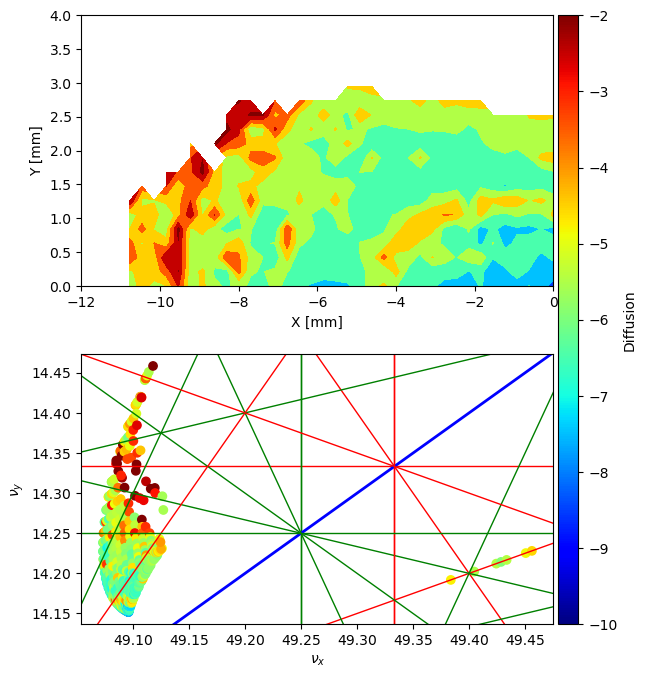

In [8]:
width = 68
widths = [58, 53, 48, 43, 63]
pxf = [-7.698, -13.797, -31.691, 16.483, 6.277]
for width, shift in zip(widths, pxf):
    print(width)
    analysis_dynapt_map(width, shift,  corr='True')